# Train Ordinary Torch Model 

If you have a torch model as an instance of [nn.Module](https://pytorch.org/docs/stable/nn.html#module) it can be easily integrated into a training or inference pipeline.

In [1]:
import sys

import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.models import resnet34

sys.path.append("../..")

from batchflow import Pipeline, B, C, D, V, W
from batchflow.models.torch import TorchModel
from batchflow.opensets import Imagenette160
from batchflow.utils import plot_images

plt.style.use('seaborn-poster')
plt.style.use('ggplot')

# Create dataset

Load [Imagenette](https://github.com/fastai/imagenette) dataset. It may take few minutes.

In [2]:
dataset = Imagenette160()

You can experiment with [MNIST](https://analysiscenter.github.io/batchflow/api/batchflow.opensets.html#mnist) and [CIFAR](https://analysiscenter.github.io/batchflow/api/batchflow.opensets.html#cifar100) datasets as well.   
Download and use them in the same manner.

# Define model config

We use [resnet34](https://arxiv.org/abs/1512.03385) model from [torchvision models zoo](https://pytorch.org/docs/stable/torchvision/models.html).    
In the config you must specify that the `body` of your model is `resnet34` module. Optionally you could add more laysers on top of the net by specifying `head`.

Let's illustrate this with example. `resnet34` model, like all the classification networks from torchvision models zoo, is customized for [imagenet](http://www.image-net.org) dataset, i.e. it has dense layer on top of it with 1000 neurons.   

Take a look at the last 4 layers of `resnet34`.

In [3]:
list(resnet34().modules())[-4:]

[Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 AdaptiveAvgPool2d(output_size=(1, 1)),
 Linear(in_features=512, out_features=1000, bias=True)]

But the `Imagenette` dataset is a subset of `Imagenet` and has only 10 classes.   
To customize the network for our dataset, we could add the `Dense` layer with 10 neurons on top of the `resnet34` model.   
However, that's not a very good model since it contains 2 extremely large dense layers.   
Instead, we remove the last `Dense` and `Global pool` layers of `resnet34`.

In [4]:
modules = list(resnet34().children())[:-2]
model = torch.nn.Sequential(*modules)

And as an alternative we  place `conv(kernel_size = 1, out_filters=10)` and `Global Pool` layers on top of the network using batchflow [ConvBlock](https://analysiscenter.github.io/batchflow/api/batchflow.models.torch.layers.html#batchflow.models.torch.layers.ConvBlock).
This block is a convenient building block for concise, yet very expressive neural networks.   

In [ ]:
config = {
          'inputs/labels/classes': 10,
          'body': model,
          'head': dict(layout='cV', filters=10, kernel_size=1),
          'loss': 'ce',
          'output/predicted': ['proba'],
          'device': 'gpu'
}

# Create train pipeline

In the pipeline we apply two preprocessing steps to the batch of images.   
First, we crop the images so the whole batch consists of the crops with the same size.   
Secondly, convert the batch of PIL images to the numpy array to make it compatible with torch models.

In [6]:
train_pipeline = (dataset.train.p
                    .init_variable('loss_history', default=[])
                    .init_model('dynamic', TorchModel, 'my_model', config)
                    .crop(shape=(160, 160), origin='center')
                    .to_array(channels='first', dtype='float32') 
                    .train_model('my_model', B.images, B.labels, fetches='loss',
                                 save_to=V('loss_history', mode='a'))
                 )

Training may take some time.

# Train the model

In [7]:
train_pipeline.run(64, shuffle=True, n_iters=3000, drop_last=True, bar=True,
                   bar_desc=W(V('loss_history')[-1].format('Loss is: {:7.7}')))

Loss is: 0.1152271: 100%|██████████| 3000/3000 [10:19<00:00,  4.84it/s] 


Take a look at the loss function plot.

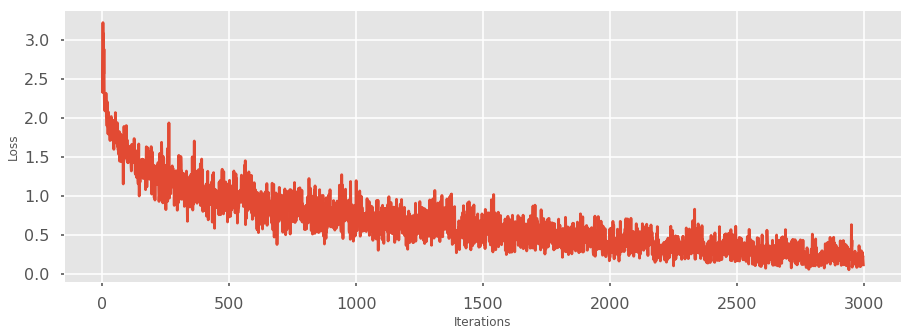

In [8]:
plt.figure(figsize=(15, 5))
plt.plot(train_pipeline.v('loss_history'))
plt.xlabel("Iterations"), plt.ylabel("Loss")
plt.show()

Training might be continued as the loss is not on plateu yet.

# Test the model 

In [9]:
test_pipeline = (dataset.test.p
                    .init_variable('predictions')
                    .init_variable('metrics')
                    .import_model('my_model', train_pipeline)
                    .crop(shape=(160,160), origin='center')
                    .to_array(channels='first', dtype='float32') # make array with images compatible with torch models
                    .predict_model('my_model', B.images,
                                   fetches='predicted_proba', save_to=V('predictions'))
                    .gather_metrics('class', targets=B.labels, predictions=V('predictions'),
                                    fmt='proba', axis=-1, save_to=V('metrics'))
                    .apply_transform_all(src='images', dst='images', 
                                     func=lambda x: np.transpose(x, (0, 2, 3, 1)).astype(int)) # make array compatible with plt.imshow()
                )

In [10]:
test_pipeline.run(200, shuffle=True, n_epochs=1, drop_last=False, bar=True)

100%|██████████| 3/3 [00:03<00:00,  1.26s/it]


In [11]:
metrics = test_pipeline.get_variable('metrics')

In [12]:
acc = metrics.evaluate('accuracy')
print('Accuracy on the test set - {:.3}'.format(acc))

Accuracy on the test set - 0.766


Generate and pass the batch of images through the trained network and look in more details at the predictions.

In [13]:
batch = test_pipeline.next_batch(10, shuffle=True)

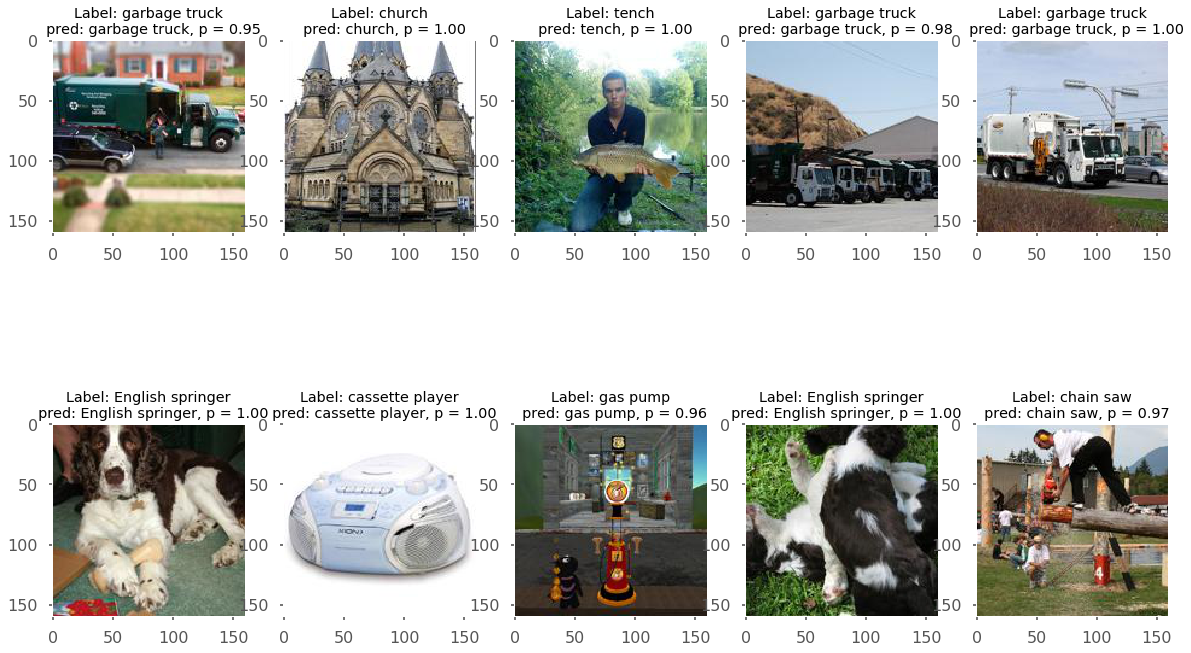

In [15]:
plot_images(batch.images, batch.labels, batch.pipeline.v('predictions'),
                        classes=dataset.classes, figsize=(20,20))

# Conclusion

In this tutorial you have learnt how easily ordinary `pytorch` models can be customized and integrated into `batchflow` pipelines.

# What's next?

You can go futher in your experiments and train the network with 2 `Dense` layers on top of it as was mentioned before to find out whether significant increase in the number of parameters will result in the increase of accuracy.